#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 13
**CH11 Used cars**

using the used-cars dataset

version 0.8 2021-07-15

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from mizani.formatters import percent_format
from plotnine import *
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import KFold
from math import sqrt


warnings.filterwarnings("ignore")
# turning off scientific notation
#pd.set_option("display.float_format", lambda x: "%.2f" % x)


In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/used-cars/clean/"
data_out = dirname + "da_case_studies/ch13-used-cars-reg/"
output = dirname + "da_case_studies/ch13-used-cars-reg/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [ ]:
# DATA IMPORT
data = pd.read_csv("/workspaces/codespaces-jupyter/data/used-cars_2cities_prep.csv")

In [4]:
# SAMPLE DESIGN

# Manage missing
data["fuel"] = data["fuel"].fillna("Missing")
data["condition"] = data["condition"].fillna("Missing")
data["drive"] = data["drive"].fillna("Missing")
data["cylinders"] = data["cylinders"].fillna("Missing")
data["transmission"] = data["transmission"].fillna("Missing")
data["type"] = data["type"].fillna("Missing")


In [5]:
# drop hybrid models then drop column
data = data.loc[data.Hybrid == 0].drop(["Hybrid"], axis=1)


In [6]:
# check frequency by fuel type
freq = data.groupby("fuel").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq


,frequency,percent,cumulative_percent
fuel,,,
Missing,1,0.190,0.190
diesel,1,0.190,0.380
gas,516,98.099,98.479
hybrid,1,0.190,98.669
other,7,1.331,100.000


In [7]:
# keep gas-fuelled vehicles
data = data.loc[data.fuel == "gas"]


In [8]:
# check frequency by vehicle condition
freq = data.groupby("condition").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq


,frequency,percent,cumulative_percent
condition,,,
Missing,207,40.116,40.116
excellent,133,25.775,65.891
fair,14,2.713,68.604
good,106,20.543,89.147
like new,53,10.271,99.418
new,3,0.581,99.999


In [9]:
data

,pricestr,area,subarea,name,condition,cylinders,drive,fuel,odometer,paintcolor,...,type,dealer,price,lnprice,year,age,lnodometer,LE,XLE,SE
2,$14850,chicago,chicago city,2015 Toyota_ Camry_,excellent,other,Missing,gas,3.572100,NaN,...,sedan,1,14850,9.605755,2015,3,1.273154,0,0,0
3,$15630,chicago,chicago city,2016 TOYOTA CAMRY,Missing,Missing,fwd,gas,1.315200,NaN,...,sedan,1,15630,9.656947,2016,2,0.273989,0,0,0
4,$850,chicago,chicago city,1993 toyota camry,good,6 cylinders,fwd,gas,18.700000,red,...,sedan,0,850,6.745236,1993,25,2.928523,0,0,0
5,$1300,chicago,chicago city,1998 toyota camry,fair,4 cylinders,fwd,gas,16.824259,grey,...,Missing,0,1300,7.170120,1998,20,2.822822,0,0,0
6,$1600,chicago,chicago city,1998 toyota camry le,Missing,Missing,Missing,gas,16.824259,NaN,...,Missing,0,1600,7.377759,1998,20,2.822822,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,$1,los angeles,North LA county,2004 toyota camry,like new,Missing,Missing,gas,11.300000,NaN,...,Missing,0,1,0.000000,2004,14,2.424803,0,0,0
545,$6800,los angeles,central LA,2012 toyota camry se,excellent,4 cylinders,Missing,gas,8.304974,NaN,...,Missing,0,6800,8.824677,2012,6,2.116855,0,0,1
546,$2000,los angeles,central LA,2008 TOYOTA CAMRY,Missing,Missing,Missing,gas,12.548112,NaN,...,Missing,0,2000,7.600903,2008,10,2.529570,0,0,0
547,$2700,los angeles,San Fernando,2002 toyota camry,excellent,4 cylinders,Missing,gas,16.100000,NaN,...,Missing,0,2700,7.901007,2002,16,2.778819,0,0,0


In [10]:
# drop vehicles in fair and new condition, trucks
data = data.loc[~data.condition.isin(["new", "fair"])]

# drop unrealistic values for price and odometer reading
data = data.loc[(data.price >= 500) & (data.price <= 25000) & (data.odometer <= 100)]

# drop if price is smaller than 1000 and condition is like new or age is less than 8
data = data.loc[
    ~((data.price < 1000) & ((data.condition == "like new") | (data.age < 8)))
]


In [11]:
data

,pricestr,area,subarea,name,condition,cylinders,drive,fuel,odometer,paintcolor,...,type,dealer,price,lnprice,year,age,lnodometer,LE,XLE,SE
2,$14850,chicago,chicago city,2015 Toyota_ Camry_,excellent,other,Missing,gas,3.572100,NaN,...,sedan,1,14850,9.605755,2015,3,1.273154,0,0,0
3,$15630,chicago,chicago city,2016 TOYOTA CAMRY,Missing,Missing,fwd,gas,1.315200,NaN,...,sedan,1,15630,9.656947,2016,2,0.273989,0,0,0
4,$850,chicago,chicago city,1993 toyota camry,good,6 cylinders,fwd,gas,18.700000,red,...,sedan,0,850,6.745236,1993,25,2.928523,0,0,0
6,$1600,chicago,chicago city,1998 toyota camry le,Missing,Missing,Missing,gas,16.824259,NaN,...,Missing,0,1600,7.377759,1998,20,2.822822,1,0,0
7,$1500,chicago,chicago city,1998 Toyota Camry,Missing,Missing,Missing,gas,16.824259,NaN,...,Missing,0,1500,7.313220,1998,20,2.822822,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,$1500,los angeles,North LA county,2001 toyota camry,excellent,6 cylinders,Missing,gas,27.000000,NaN,...,Missing,0,1500,7.313220,2001,17,3.295837,0,0,0
545,$6800,los angeles,central LA,2012 toyota camry se,excellent,4 cylinders,Missing,gas,8.304974,NaN,...,Missing,0,6800,8.824677,2012,6,2.116855,0,0,1
546,$2000,los angeles,central LA,2008 TOYOTA CAMRY,Missing,Missing,Missing,gas,12.548112,NaN,...,Missing,0,2000,7.600903,2008,10,2.529570,0,0,0
547,$2700,los angeles,San Fernando,2002 toyota camry,excellent,4 cylinders,Missing,gas,16.100000,NaN,...,Missing,0,2700,7.901007,2002,16,2.778819,0,0,0


In [12]:
# check frequency by transmission
freq = data.groupby("transmission").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq


,frequency,percent,cumulative_percent
transmission,,,
automatic,478,98.557,98.557
manual,7,1.443,100.000


In [13]:
data = data.loc[~(data.transmission == "manual")]


In [14]:
# check frequency by transmission
freq = data.groupby("type").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq


,frequency,percent,cumulative_percent
type,,,
Missing,223,46.653,46.653
SUV,1,0.209,46.862
convertible,6,1.255,48.117
coupe,19,3.975,52.092
pickup,1,0.209,52.301
sedan,227,47.490,99.791
wagon,1,0.209,100.000


In [15]:
# drop if truck
data = data.loc[~(data.type == "truck")]
# drop pricestr
data = data.drop(["pricestr"], axis=1)


In [16]:
# DATA GENERATION & DESCRIPTIVES
# CONDITION
data["cond_excellent"] = np.where(data["condition"] == "excellent", 1, 0)
data["cond_good"] = np.where(data["condition"] == "good", 1, 0)
data["cond_likenew"] = np.where(data["condition"] == "like new", 1, 0)
# cylinders
data["cylind6"] = np.where(data["cylinders"] == "6 cylinders", 1, 0)
data.cylinders.value_counts()
data.cylind6.value_counts()
# age: quadratic, cubic
data["agesq"] = data["age"] ** 2
data["agecu"] = data["age"] ** 3
# odometer quadratic
data["odometersq"] = data["odometer"] ** 2


In [17]:
# Frequency tables

# area
data.groupby("area").agg(frequency=("price", "size"), mean=("price", np.mean))


,frequency,mean
area,,
chicago,281,6060.975089
los angeles,197,5518.253807


In [18]:
# focus only on Chicago
data = data.loc[data.area == "chicago"]


In [19]:
# condition
data.groupby("condition").agg(frequency=("price", "size"), mean=("price", np.mean))


,frequency,mean
condition,,
Missing,124,6611.161290
excellent,75,6724.186667
good,67,3988.179104
like new,15,7455.200000


In [20]:
# drive
data.groupby("drive").agg(frequency=("price", "size"), mean=("price", np.mean))


,frequency,mean
drive,,
4wd,4,10168.750000
Missing,106,4575.094340
fwd,169,6893.485207
rwd,2,6250.000000


In [21]:
# dealer
data.groupby("dealer").agg(frequency=("price", "size"), mean=("price", np.mean))


,frequency,mean
dealer,,
0,193,4402.181347
1,88,9699.011364


In [22]:
# data summary
data.loc[
    :,
    [
        "age",
        "odometer",
        "LE",
        "XLE",
        "SE",
        "cond_likenew",
        "cond_excellent",
        "cond_good",
        "cylind6",
    ],
].describe()


,age,odometer,LE,XLE,SE,cond_likenew,cond_excellent,cond_good,cylind6
count,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000
mean,12.298932,12.521702,0.192171,0.071174,0.064057,0.053381,0.266904,0.238434,0.145907
std,5.892153,5.172572,0.394710,0.257575,0.245291,0.225193,0.443131,0.426886,0.353643
min,1.000000,0.231900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,8.140000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13.000000,13.655900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,17.000000,16.430000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,27.000000,25.300000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
# Histograms not in the textbook


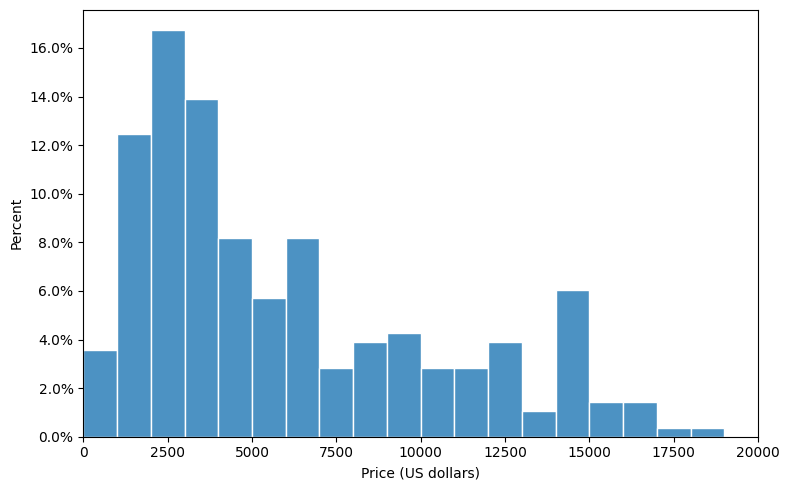

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

plt.figure(figsize=(8, 5))
sns.histplot(
    data["price"],
    bins=20,
    binrange=(0, 20000),
    color="tab:blue",  
    stat="probability",
    edgecolor="white",
    alpha=0.8
)
plt.xlim(0, 20000)
plt.xlabel("Price (US dollars)")
plt.ylabel("Percent")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(range(0, 20001, 2500))
plt.grid(False)
plt.tight_layout()
plt.show()


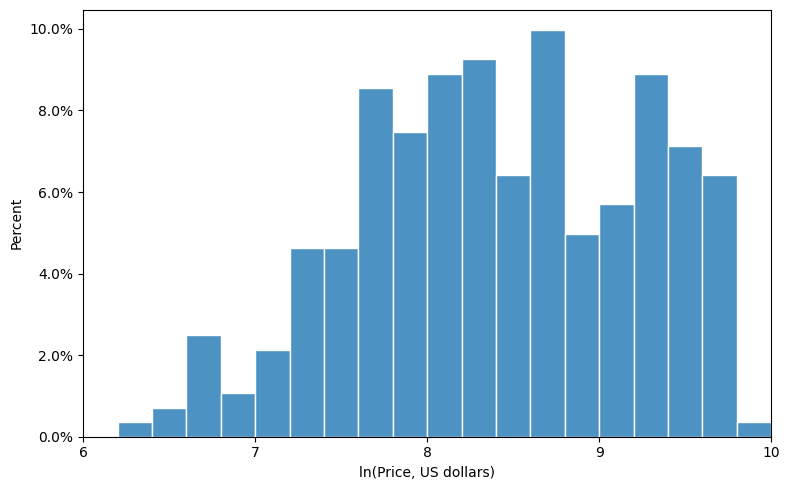

In [25]:
plt.figure(figsize=(8, 5))
sns.histplot(
    data["lnprice"],
    bins=20,
    binrange=(6, 10),
    color="tab:blue",  
    stat="probability",
    edgecolor="white",
    alpha=0.8
)
plt.xlim(6, 10)
plt.xlabel("ln(Price, US dollars)")
plt.ylabel("Percent")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(range(6, 11))
plt.grid(False)
plt.tight_layout()
plt.show()



### Regression analysis

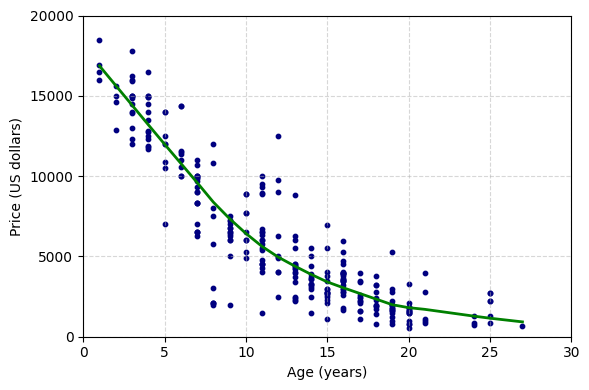

In [26]:
from statsmodels.nonparametric.smoothers_lowess import lowess

fig, ax = plt.subplots(figsize=(6, 4))

# Scatter plot for predicted probability
ax.scatter(data["age"], data["price"], s=10, color="navy", label="Predicted probability")

# LOWESS smoothing line
# Increase precision by lowering the 'frac' parameter (e.g., frac=0.5)
lowess_smoothed = lowess(data["price"], data["age"], frac=0.5)
ax.plot(lowess_smoothed[:, 0], lowess_smoothed[:, 1], color="green", linewidth=2, label="LOWESS (frac=0.3)")

plt.xlabel("Age (years)")
plt.ylabel("Price (US dollars)")
plt.xlim(0, 30)
plt.ylim(0, 20000)
plt.xticks(range(0, 31, 5))
plt.yticks(range(0, 20001, 5000))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [27]:
data.describe()


,odometer,dealer,price,lnprice,year,age,lnodometer,LE,XLE,SE,cond_excellent,cond_good,cond_likenew,cylind6,agesq,agecu,odometersq
count,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000
mean,12.521702,0.313167,6060.975089,8.410963,2005.701068,12.298932,2.399433,0.192171,0.071174,0.064057,0.266904,0.238434,0.053381,0.145907,185.857651,3141.096085,183.453306
std,5.172572,0.464609,4490.818067,0.812821,5.892153,5.892153,0.590359,0.394710,0.257575,0.245291,0.443131,0.426886,0.225193,0.353643,150.578697,3504.795719,127.300387
min,0.231900,0.000000,550.000000,6.309918,1991.000000,1.000000,-1.461449,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.053778
25%,8.140000,0.000000,2500.000000,7.824046,2001.000000,7.000000,2.096790,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.000000,343.000000,66.259600
50%,13.655900,0.000000,4400.000000,8.389359,2005.000000,13.000000,2.614172,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,169.000000,2197.000000,186.483605
75%,16.430000,1.000000,8995.000000,9.104425,2011.000000,17.000000,2.799109,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,289.000000,4913.000000,269.944900
max,25.300000,1.000000,18495.000000,9.825255,2017.000000,27.000000,3.230804,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,729.000000,19683.000000,640.090000


In [28]:
data.columns

Index(['area', 'subarea', 'name', 'condition', 'cylinders', 'drive', 'fuel',
       'odometer', 'paintcolor', 'size', 'transmission', 'type', 'dealer',
       'price', 'lnprice', 'year', 'age', 'lnodometer', 'LE', 'XLE', 'SE',
       'cond_excellent', 'cond_good', 'cond_likenew', 'cylind6', 'agesq',
       'agecu', 'odometersq'],
      dtype='object')

## Linear regressions

In [29]:
# Model 1: Linear regression on age
model1 = "price ~ age + agesq"

# Models 2-5: Multiple linear regressions
# note: condition - missing will be baseline for regs
model2 = "price ~ age + agesq + odometer"
model3 = "price ~ age + agesq + odometer + odometersq + LE + cond_excellent + cond_good + dealer"
model4 = "price ~ age + agesq + odometer + odometersq + LE + XLE + SE + cond_likenew + cond_excellent + cond_good + cylind6 + dealer"
model5 = "price ~ age + agesq + odometer + odometersq + LE * age + XLE * age + SE * age + cond_likenew * age + cond_excellent * age + cond_good * age + cylind6 * age + odometer * age + dealer * age"

model_equations = [model1, model2, model3, model4, model5]

In [30]:
# regression results for model 1
result1=smf.ols(model1, data=data).fit(cov_type="HC1")
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     1065.
Date:                Mon, 28 Jul 2025   Prob (F-statistic):          4.54e-131
Time:                        23:06:23   Log-Likelihood:                -2497.9
No. Observations:                 281   AIC:                             5002.
Df Residuals:                     278   BIC:                             5013.
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.837e+04    353.534     51.948      0.0

In [31]:
# Matrix form

X1 = data[['age', 'agesq']]  
y2 = data['price']          

model1 = LinearRegression()
model1.fit(X1, y2)
print(model1.coef_, model1.intercept_)

[-1530.08828422    35.0482224 ] 18365.447142801124


Estimate ALL regressions

In [32]:
regs = []
for equation in model_equations:
    regs.append(smf.ols(equation, data).fit(cov_type="HC1"))

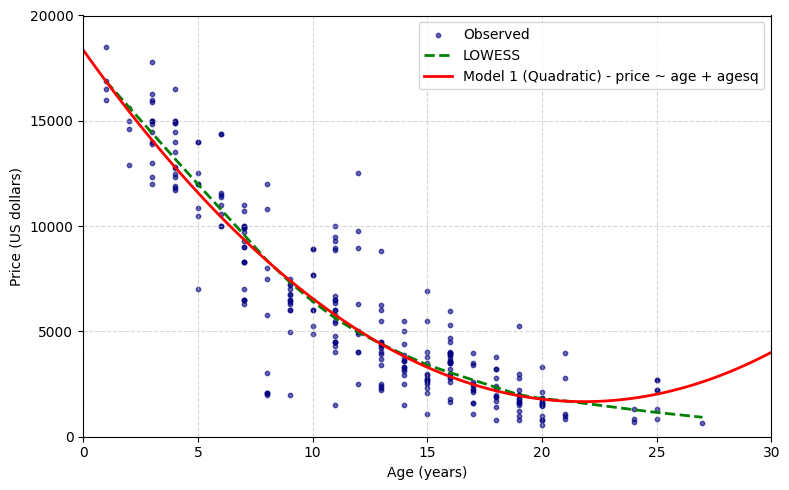

In [33]:
import numpy as np

color = ["navy", "green"]

plt.figure(figsize=(8, 5))

# Scatter plot of price vs age
plt.scatter(data["age"], data["price"], s=10, color=color[0], alpha=0.6, label="Observed")

# LOWESS smoothing line
plt.plot(lowess_smoothed[:, 0], lowess_smoothed[:, 1], color=color[1], linestyle="--", linewidth=2, label="LOWESS")

# Model 1 prediction line
age_grid = np.linspace(0, 30, 100)
model1_pred = regs[0].predict(exog=dict(age=age_grid, agesq=age_grid**2))
plt.plot(age_grid, model1_pred, color="red", linewidth=2, label="Model 1 (Quadratic) - price ~ age + agesq")

plt.xlabel("Age (years)")
plt.ylabel("Price (US dollars)")
plt.xlim(0, 30)
plt.ylim(0, 20000)
plt.xticks(np.arange(0, 31, 5))
plt.yticks(np.arange(0, 20001, 5000))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### Table 13.2 Regression models for predicting used car price

In [34]:
stargazer.Stargazer(regs[:5])


In [35]:
# not using startgazer

import statsmodels.formula.api as smf


results = [smf.ols(eq, data=data).fit() for eq in model_equations]

for i, res in enumerate(results, 1):
    print(f"\nModel {i} Summary:")
    print(res.summary())


Model 1 Summary:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     767.7
Date:                Mon, 28 Jul 2025   Prob (F-statistic):          6.17e-114
Time:                        23:06:23   Log-Likelihood:                -2497.9
No. Observations:                 281   AIC:                             5002.
Df Residuals:                     278   BIC:                             5013.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.837e+04    407.859  

In [36]:
# Display summary tables for Model 2 and Model 4
display(regs[1].summary().tables[1])
display(regs[3].summary().tables[1])

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,1.886e+04,313.505,60.159,0.000,1.82e+04,1.95e+04
age,-1149.2234,70.123,-16.389,0.000,-1286.663,-1011.784
agesq,27.6534,2.558,10.811,0.000,22.640,32.667
odometer,-303.8405,31.105,-9.768,0.000,-364.805,-242.876


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,1.896e+04,451.933,41.961,0.000,1.81e+04,1.98e+04
age,-836.6435,78.535,-10.653,0.000,-990.569,-682.718
agesq,17.6303,2.472,7.131,0.000,12.785,22.476
odometer,-788.7017,84.644,-9.318,0.000,-954.601,-622.802
odometersq,19.2005,2.662,7.212,0.000,13.982,24.419
LE,-20.4815,207.509,-0.099,0.921,-427.192,386.229
XLE,301.6854,365.083,0.826,0.409,-413.864,1017.235
SE,1338.7874,527.717,2.537,0.011,304.481,2373.094
cond_likenew,558.6742,393.994,1.418,0.156,-213.539,1330.888
cond_excellent,190.4031,208.324,0.914,0.361,-217.905,598.711


In [37]:
import statsmodels.api as sm

# Prepare DataFrame for prediction
predict_df = pd.DataFrame({'age': age_grid, 'agesq': age_grid**2})

# Get prediction and prediction interval for Model 1
pred = regs[0].get_prediction(predict_df)
pred_int = pred.summary_frame(alpha=0.2)  # 80% interval (change alpha as needed)

print(pred_int[['mean', 'obs_ci_lower', 'obs_ci_upper']])

            mean  obs_ci_lower  obs_ci_upper
0   18365.447143  16059.048892  20671.845394
1   17905.002412  15602.308517  20207.696307
2   17450.994454  15151.718159  19750.270748
3   17003.423267  14707.291902  19299.554631
4   16562.288851  14269.043621  18855.534082
..           ...           ...           ...
95   3363.383788    996.005812   5730.761764
96   3514.432378   1138.201524   5890.663231
97   3671.917739   1286.324722   6057.510756
98   3835.839872   1440.360828   6231.318917
99   4006.198777   1600.295467   6412.102088

[100 rows x 3 columns]


Model 5 - not displayed in book

In [38]:
conf_inter2 = regs[2].conf_int(alpha=0.05)  # alpha=0.05 for 95% CI
print(conf_inter2)

                           0             1
Intercept       18610.767535  20253.008182
age             -1034.878281   -712.068169
agesq              13.114333     23.313265
odometer         -952.854729   -606.940701
odometersq         13.448338     24.168385
LE               -368.931953    425.157607
cond_excellent   -204.130892    557.104335
cond_good        -145.655695    732.377162
dealer            133.232736   1012.719440


In [39]:
regs[3].summary(),

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                  price   R-squared:                       0.919
 Model:                            OLS   Adj. R-squared:                  0.916
 Method:                 Least Squares   F-statistic:                     316.4
 Date:                Mon, 28 Jul 2025   Prob (F-statistic):          1.62e-150
 Time:                        23:06:23   Log-Likelihood:                -2407.8
 No. Observations:                 281   AIC:                             4842.
 Df Residuals:                     268   BIC:                             4889.
 Df Model:                          12                                         
 Covariance Type:                  HC1                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
 -----------------------------------------------------------------

In [40]:
regs[4].summary(),

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                  price   R-squared:                       0.923
 Model:                            OLS   Adj. R-squared:                  0.917
 Method:                 Least Squares   F-statistic:                     201.9
 Date:                Mon, 28 Jul 2025   Prob (F-statistic):          2.33e-147
 Time:                        23:06:23   Log-Likelihood:                -2400.5
 No. Observations:                 281   AIC:                             4845.
 Df Residuals:                     259   BIC:                             4925.
 Df Model:                          21                                         
 Covariance Type:                  HC1                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
 -------------------------------------------------------------

## Cross validation

Use custom function `ols_crossvalidator` for cross validation

I run sklearn library

In [41]:
from sklearn.model_selection import KFold, cross_val_score

Set n_fold = 4 for 4-fold cross-validation

In [42]:
n_fold = 4

Cross-validate models

In [ ]:
# for model2: model2 = "price ~ age + agesq + odometer"
# Define predictors and target
X = data[["age", "agesq", "odometer"]]  
y = data["price"]                       

# 2. Set up KFold  with 5. folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list = []

# 3. Loop through each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = sqrt(mean_squared_error(y_test, y_pred))
    rmse_list.append(rmse)

# 4. Average RMSE
average_rmse = np.mean(rmse_list)

print("RMSEs for each fold:", rmse_list)
print("Average RMSE:", average_rmse)

RMSEs for each fold: [1649.78461830922, 1638.748453505182, 1325.5233013689963, 1276.5842377501262, 1441.4061811610047]
Average RMSE: 1466.4093584189056


In [101]:
k_fold = 5

In [102]:
# for all models and using k fold = 10

def ols_crossvalidator(equation, data, n_fold=k_fold, average_rmse=False):
    kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)
    rmse_list = []

    for train_index, test_index in kf.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        model = smf.ols(equation, data=train_data).fit()
        y_pred = model.predict(test_data)
        y_true = test_data[equation.split("~")[0].strip()]

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        rmse_list.append(rmse)

    if average_rmse:
        return np.mean(rmse_list)
    else:
        return rmse_list

cv_list = []
for equation in model_equations:
    result = ols_crossvalidator(equation, data, n_fold=k_fold, average_rmse=False)
    cv_list.append(result)
cv_list


[[np.float64(1915.951471794988),
  np.float64(1750.8887329883366),
  np.float64(1791.4244670178773),
  np.float64(1635.681828411888),
  np.float64(1840.122843390686)],
 [np.float64(1649.7846183092306),
  np.float64(1638.7484535051879),
  np.float64(1325.5233013690122),
  np.float64(1276.5842377501272),
  np.float64(1441.4061811609897)],
 [np.float64(1488.1145188686874),
  np.float64(1560.3344066442596),
  np.float64(1296.0347541426688),
  np.float64(1297.3521290366527),
  np.float64(1250.3924774027546)],
 [np.float64(1486.2773012227249),
  np.float64(1476.831204507443),
  np.float64(1446.1524185978274),
  np.float64(1342.1148486784377),
  np.float64(1177.9397440378157)],
 [np.float64(1444.7092323264278),
  np.float64(1537.8722214838729),
  np.float64(1445.2288902618561),
  np.float64(1317.3497842187976),
  np.float64(1213.850984295206)]]

### Table 13.4 Car price models estimated using all original data and measures of fit using all original data

In [ ]:
summary = pd.DataFrame({
    "Model": ["Model " + str(i + 1) for i in range(len(model_equations))],
    "Nvars": [1, 2, 5, 6, 6],  # adjust based on your actual model variables [1, 2, 5, 6, 6]
    "Coefficients": [len(reg.params) for reg in regs],
    "R-squared": [reg.rsquared for reg in regs],
    "RMSE": [np.mean(cv) for cv in cv_list],
    "BIC": [reg.bic for reg in regs],
})

summary = summary[["Model", "Nvars", "Coefficients", "R-squared", "RMSE", "BIC"]]
summary.set_index("Model", inplace=True)
summary.round(2)


,Nvars,Coefficients,R-squared,RMSE,BIC
Model,,,,,
Model 1,1,3,0.85,1734.34,5012.68
Model 2,2,4,0.90,1445.43,4904.63
Model 3,5,9,0.91,1347.02,4887.51
Model 4,6,13,0.92,1334.68,4888.84
Model 5,6,22,0.92,1353.55,4925.14


In [ ]:
summary = pd.DataFrame({
    "Model": ["Model " + str(i + 1) for i in range(len(model_equations))],
    "Nvars": [1, 2, 5, 6, 6],  # adjust based on your actual model variables [1, 2, 5, 6, 6]
    "Coefficients": [len(reg.params) for reg in regs],
    "R-squared": [reg.rsquared for reg in regs],
    "RMSE": [np.mean(cv) for cv in cv_list],
    "BIC": [reg.bic for reg in regs],
})

summary = summary[["Model", "Nvars", "Coefficients", "R-squared", "RMSE", "BIC"]]
summary.set_index("Model", inplace=True)
summary.round(2)


### Table 13.5 Car price models estimated and evaluated using 4-fold cross-validation and RMSE

In [93]:
pd.DataFrame(
    cv_list,
    index=["Model " + str(i + 1) for i in range(len(cv_list))],
    columns=["Fold" + str(i + 1) for i in range(len(cv_list[0]))],
).assign(Average=lambda x: x.mean(axis=1)).T.round().astype(int)

,Model 1,Model 2,Model 3,Model 4,Model 5
Fold1,1916,1650,1488,1486,1445
Fold2,1751,1639,1560,1477,1538
Fold3,1791,1326,1296,1446,1445
Fold4,1636,1277,1297,1342,1317
Fold5,1840,1441,1250,1178,1214
Average,1787,1466,1378,1386,1392


In [82]:
data['agesq']

2        9
3        4
4      625
6      400
7      400
      ... 
328      9
330      4
331    225
333     64
336    121
Name: agesq, Length: 281, dtype: int64

## Plots to visualize the diff between k_folds=4 and k_folds=10

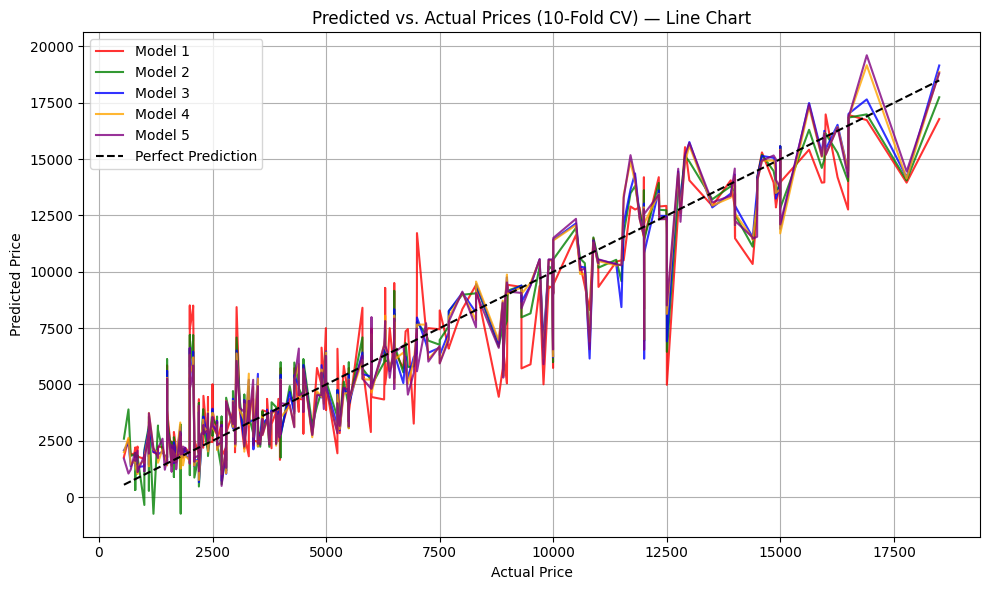

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
results = []

for formula in model_equations:
    preds = []
    actuals = []
    for train_idx, test_idx in kf.split(data):
        train_data = data.iloc[train_idx]
        test_data = data.iloc[test_idx]
        model = smf.ols(formula, data=train_data).fit()
        y_pred = model.predict(test_data)
        preds.extend(y_pred)
        actuals.extend(test_data['price'])
    results.append((np.array(actuals), np.array(preds)))

# Sort by actual price to align line charts
sorted_indices = np.argsort(results[0][0])  # use actuals from model 1 for consistent sorting
sorted_actual = results[0][0][sorted_indices]

# Plot
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue', 'orange', 'purple']

for i, (actual, pred) in enumerate(results):
    sorted_pred = pred[sorted_indices]
    plt.plot(sorted_actual, sorted_pred, label=f'Model {i+1}', color=colors[i], alpha=0.8)

# Perfect prediction line
plt.plot(sorted_actual, sorted_actual, 'k--', label='Perfect Prediction')

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs. Actual Prices (10-Fold CV) — Line Chart")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

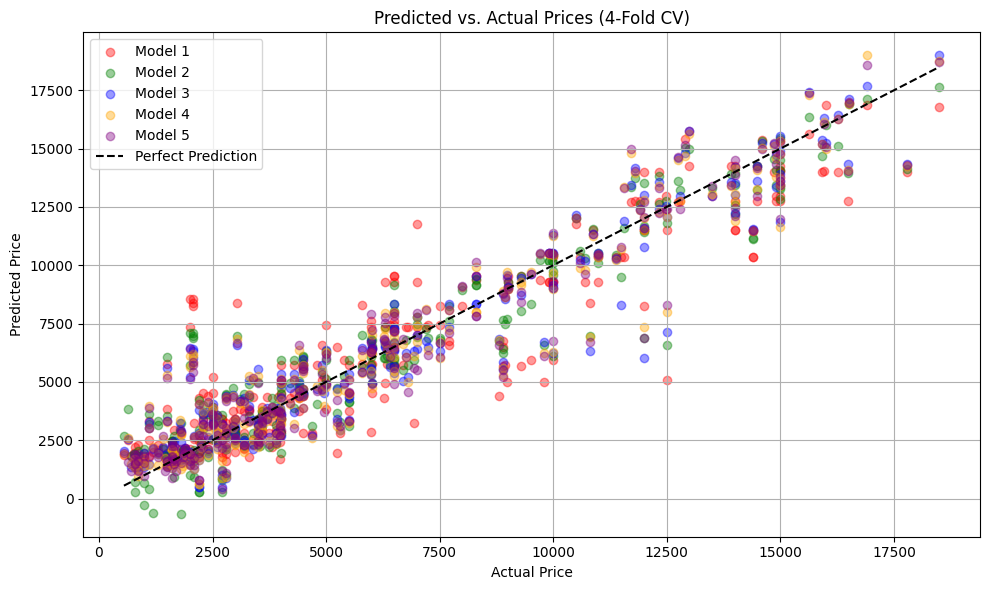

In [94]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)
results = []

for formula in model_equations:
    preds = []
    actuals = []
    for train_idx, test_idx in kf.split(data):
        train_data = data.iloc[train_idx]
        test_data = data.iloc[test_idx]
        model = smf.ols(formula, data=train_data).fit()
        y_pred = model.predict(test_data)
        preds.extend(y_pred)
        actuals.extend(test_data['price'])
    results.append((actuals, preds))

# Plot
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue', 'orange', 'purple']
for i, (actual, pred) in enumerate(results):
    plt.scatter(actual, pred, alpha=0.4, label=f'Model {i+1}', color=colors[i])

plt.plot(
    [data['price'].min(), data['price'].max()],
    [data['price'].min(), data['price'].max()],
    'k--', label='Perfect Prediction'
)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs. Actual Prices (4-Fold CV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Prediction

In [48]:
data = data.loc[
    :,
    [
        "age",
        "agesq",
        "odometer",
        "odometersq",
        "SE",
        "LE",
        "XLE",
        "cond_likenew",
        "cond_excellent",
        "cond_good",
        "dealer",
        "price",
        "cylind6",
    ],
]


In [49]:
data.dtypes


age                 int64
agesq               int64
odometer          float64
odometersq        float64
SE                  int64
LE                  int64
XLE                 int64
cond_likenew        int64
cond_excellent      int64
cond_good           int64
dealer              int64
price               int64
cylind6             int64
dtype: object

In [50]:
new = pd.DataFrame(
    pd.Series(
        {
            "age": 10,
            "agesq": 10**2,
            "odometer": 12,
            "odometersq": 12**2,
            "SE": 0,
            "LE": 1,
            "XLE": 0,
            "cond_likenew": 0,
            "cond_excellent": 1,
            "cond_good": 0,
            "dealer": 0,
            "price": np.nan,
            "cylind6": 0,
        }
    )
).T
new


,age,agesq,odometer,odometersq,SE,LE,XLE,cond_likenew,cond_excellent,cond_good,dealer,price,cylind6
0,10.0,100.0,12.0,144.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0


In [51]:
pd.concat([new, new], ignore_index=True)

,age,agesq,odometer,odometersq,SE,LE,XLE,cond_likenew,cond_excellent,cond_good,dealer,price,cylind6
0,10.0,100.0,12.0,144.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0
1,10.0,100.0,12.0,144.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0


In [52]:
reg1 = regs[0]
reg3 = regs[2]

In [53]:
reg1.resid.describe()


count    2.810000e+02
mean     1.076117e-10
std      1.758313e+03
min     -6.367827e+03
25%     -8.636628e+02
50%     -1.013318e+02
75%      8.936205e+02
max      7.448668e+03
dtype: float64

In [54]:
(reg3.fittedvalues - data.price).describe()


count    2.810000e+02
mean     5.626568e-11
std      1.325029e+03
min     -5.782218e+03
25%     -5.845089e+02
50%      1.056349e+01
75%      6.282881e+02
max      4.245894e+03
dtype: float64

### Table 13.3 Point predictions and interval predictions for a specific car, using models 1 and 3

Use custom function `point_predict_with_conf_int` to extract point and interval prediction for a new datapoint.

In [55]:
help(point_predict_with_conf_int)

NameError: name 'point_predict_with_conf_int' is not defined

In [ ]:
p95 = pd.DataFrame(
    [
        point_predict_with_conf_int(reg1, new, interval_precision=0.95, round_n=0),
        point_predict_with_conf_int(reg3, new, interval_precision=0.95, round_n=0),
    ],
    index=["Model 1", "Model 2"],
).T
p95.loc["Prediction Interval (95%)", :] = p95.loc["Prediction Interval (95%)", :].apply(
    format_confidence_interval
)

In [ ]:
p80 = pd.DataFrame(
    [
        point_predict_with_conf_int(reg1, new, interval_precision=0.8, round_n=0),
        point_predict_with_conf_int(reg3, new, interval_precision=0.8, round_n=0),
    ],
    index=["Model 1", "Model 2"],
).T
p80.loc["Prediction Interval (80%)", :] = p80.loc["Prediction Interval (80%)", :].apply(
    format_confidence_interval
)

In [ ]:
p80.append(p95.loc["Prediction Interval (95%)"])

,Model 1,Model 2
Point prediction,6569,6073
Prediction Interval (80%),[4299–8840],[4323–7822]
Prediction Interval (95%),[3097–10042],[3397–8749]
